<a href="https://colab.research.google.com/github/vicgalle/sgmcmc-force/blob/master/Gaussian_example_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Grab newest JAX version.
!pip install --upgrade -q jax==0.1.54 jaxlib==0.1.37

use_tpu = True
if use_tpu:
# Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  import os
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print(config.FLAGS.jax_backend_target)

     |████████████████████████████████| 256kB 3.4MB/s 
     |████████████████████████████████| 25.4MB 1.2MB/s 
grpc://10.5.67.234:8470


In [0]:
import jax
import jax.numpy as np
from jax import random

key = random.PRNGKey(0)

In [134]:
d = 2
N = 6

key, subkey = random.split(key)
x0 = 3. + 0.25*random.normal(key, (N, d))
print(x0)

[[3.2593813 3.1996868]
 [2.9687963 3.0197053]
 [3.0067084 3.0664346]
 [2.8299875 3.3063397]
 [2.9118252 2.6788821]
 [3.0338914 3.0519772]]


In [0]:
eta = 0.01
s = 1.
h = 2*s**2

def K(x):
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    norm = np.einsum('ijk,ijk->ij', xmx, xmx)
    return np.exp(-(norm)/h)

def g_K(x):
    # we avoid calling autograd since the function is non-scalar, for better efficiency
    xmx = np.expand_dims(x, 0) - np.expand_dims(x, 1)
    return np.expand_dims(K(x), -1) * (2.*xmx/h)

def logp(x):
    # in this simple case we can sum everything...
    return -np.sum(x**2)

In [0]:
from jax import grad, jit

def svgd(x0, logp, T = 100):
    
    x = x0
    g_logp = grad(logp)
    xs = [x0]

    update_svgd = jit( lambda x : K(x) @ g_logp(x) + g_K(x).sum(0) ) 

    for i in range(T):
        x = x + eta * update_svgd(x)   
        xs.append(x)
    return x, np.asarray(xs)

In [137]:
x, xs = svgd(x0, logp, T=200)
x

DeviceArray([[ 1.001397  ,  0.44423074],
             [-0.9243896 , -0.38732374],
             [-0.30366102, -0.00298705],
             [-0.31783342,  1.0628091 ],
             [ 0.48936245, -0.9865278 ],
             [ 0.19265223, -0.05246079]], dtype=float32)

In [138]:
xs.mean(), xs[:, :, 0].std(), xs[:, :, 1].std()

(DeviceArray(0.18421564, dtype=float32),
 DeviceArray(0.6957327, dtype=float32),
 DeviceArray(0.73811656, dtype=float32))

In [0]:
def sgldr(x0, logp, T = 100, key = key):
    
    x = x0
    g_logp = grad(logp)
    xs = [x0]

    update_sgldr = jit( lambda x, key : ( eta * ( K(x) @ g_logp(x) + g_K(x).sum(0)) + np.linalg.cholesky(2 * eta * K(x)) @ random.normal(key, (N, d)), random.split(key)[0] ) )

    for i in range(T):
        x_upd, key = update_sgldr(x, key)
        x = x + x_upd
        xs.append(x)
    return x, np.asarray(xs)

In [140]:
x, xs_sgldr = sgldr(x0, logp, 200, key)
x

DeviceArray([[ 0.7705375 ,  0.04373644],
             [-1.867171  ,  0.7200786 ],
             [ 0.5204219 , -0.44146377],
             [ 0.3483814 ,  0.9848946 ],
             [-0.61981845, -0.9191437 ],
             [ 1.2486017 , -0.43471223]], dtype=float32)

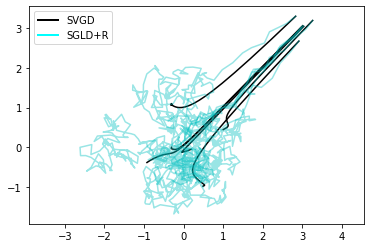

In [144]:
plt.plot(xs[:, :,0], xs[:, :,1], 'k-')
plt.plot(xs_sgldr[:, :,0], xs_sgldr[:, :,1], 'c', alpha=0.4)

from matplotlib.lines import Line2D
colors = ['black', 'cyan']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
labels = ['SVGD', 'SGLD+R']
plt.legend(lines, labels)

plt.axis('equal');


plt.savefig('svgd_vs_sgldr.png', dpi=300)

from google.colab import files
files.download('svgd_vs_sgldr.png')

In [142]:
xs_sgldr.mean(), xs_sgldr[:, :, 0].std(), xs_sgldr[:, :, 1].std()

(DeviceArray(0.0837023, dtype=float32),
 DeviceArray(0.8976763, dtype=float32),
 DeviceArray(0.86983895, dtype=float32))